In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.applications.mobilenet import preprocess_input
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

Get the [data](https://github.com/ardamavi/Sign-Language-Digits-Dataset)

In [25]:
def organize_Data():
    # Organize data into train, valid, test dirs
    os.chdir('../data/Sign-Language-Digits-Dataset/Dataset')
    if os.path.isdir('train/0/') is False: 
        os.mkdir('train')
        os.mkdir('valid')
        os.mkdir('test')

        for i in range(0, 10):
            shutil.move(f'{i}', 'train')
            os.mkdir(f'valid/{i}')
            os.mkdir(f'test/{i}')

            valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
            for j in valid_samples:
                shutil.move(f'train/{i}/{j}', f'valid/{i}')

            test_samples = random.sample(os.listdir(f'train/{i}'), 5)
            for k in test_samples:
                shutil.move(f'train/{i}/{k}', f'test/{i}')
    os.chdir('../..')

# organize_Data()

In [21]:
train_path = '../data/Sign-Language-Digits-Dataset/train'
valid_path = '../data/Sign-Language-Digits-Dataset/valid'
test_path = '../data/Sign-Language-Digits-Dataset/test'

In [23]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [24]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [26]:
x = mobile.layers[-6].output

In [27]:
output = Dense(units=10, activation='softmax')(x)

In [30]:
model = Model(inputs=mobile.input, outputs=output)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [32]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [34]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 73s - loss: 0.6172 - accuracy: 0.8125 - val_loss: 0.3107 - val_accuracy: 0.9133
Epoch 2/30
172/172 - 67s - loss: 0.1088 - accuracy: 0.9836 - val_loss: 0.1422 - val_accuracy: 0.9767
Epoch 3/30
172/172 - 67s - loss: 0.0585 - accuracy: 0.9907 - val_loss: 0.1074 - val_accuracy: 0.9933
Epoch 4/30
172/172 - 67s - loss: 0.0308 - accuracy: 0.9988 - val_loss: 0.0894 - val_accuracy: 0.9900
Epoch 5/30
172/172 - 67s - loss: 0.0209 - accuracy: 0.9988 - val_loss: 0.0727 - val_accuracy: 0.9933
Epoch 6/30
172/172 - 67s - loss: 0.0156 - accuracy: 0.9988 - val_loss: 0.0786 - val_accuracy: 0.9933
Epoch 7/30
172/172 - 68s - loss: 0.0198 - accuracy: 0.9988 - val_loss: 0.0756 - val_accuracy: 0.9933
Epoch 8/30
172/172 - 67s - loss: 0.0105 - accuracy: 0.9994 - val_loss: 0.0740 - val_accuracy: 0.9900
Epoch 9/30
172/172 - 67s - loss: 0.0085 - accuracy: 0.9994 - val_loss: 0.0763 - val_accuracy: 0.9967
Epoch 10/30
172/172 - 67s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1004 - val_accura

In [36]:
predictions = model.predict(x=test_batches, verbose=0)

In [38]:
test_labels = test_batches.classes

In [39]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


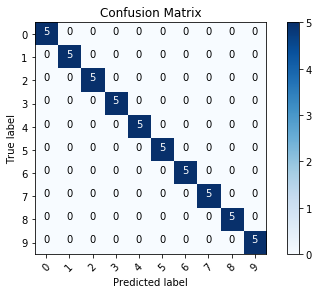

In [42]:
plot_confusion_matrix(cm=cm, classes=list(test_batches.class_indices.keys()), title='Confusion Matrix')

As we can see the model gives an accuracy of 100% which is amazing